# Prototype for planning / opertion model

owner: Yi Ju. last updated: 2022/08/26

**contact the owner before you edit this notebook (incl. run)**

**AND very clearly mark where you edit (and why)**

In [1]:
import os
import sys
src_path = sys.path[0].replace("notebooks", "src")
if src_path not in sys.path:
    sys.path.append(src_path)
out_path = sys.path[0].replace("notebooks", "output")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from battery_model import *
from optimizer import *

from predictor import Predictor_tou_SDGE_DA

In [2]:
tou_pred = Predictor_tou_SDGE_DA(None)
tou = tou_pred.get_prediction(datetime(2019,1,1,0,0), 96, 0.25)

opt_params_sample = {
    "K": 96,
    "delta": 0.25,
    "S": 1, # number of scenarios (energy profiles). can omit, default 1
    "S_prob": None, 
    # if S != 1, params in "loads", "ev" should be list of length S
    ### loads
    "load_bld": 5 * np.sin(np.linspace(0, 2*np.pi, 96)) + 10,
    "load_pv": np.maximum(0, -np.linspace(-6,6,96)**2+20),
    "energy_price_buy": tou, # $/kWh
    "energy_price_sell": 0.6, # if None, sell is not allowed. can omit
    ### demand charge
    "dc_price": 0.6, # $/day. ref: 18 $/mon
    "dc_prev_max": None, # track p_grid_max in the same billing cycle. can omit
    "p_grid_max": "1.5",    # "1.5" means 1.5 x max(load_bld), a float, e.g., 1000, means 1000 kW, default: None
    ### battery (here I only consider one battery)
    """ Battery params will be provided by battery object """
    # "bat_capacity": None, # if none, capacity is optimized
    # "bat_p_max": 3, # i.e., capacity (kWh) / p_bat_max (kW) = 3 (h)
    # "bat_p_min": 3, # can omit, then p_bat_min = p_bat_max
    # "bat_price": 100, # $/kWh, ref: Tesla Powerwall
    # "bat_efficacy": 0.98, 
    # "bat_life_0": 3650, # days.
    # "bat_cycle_0": 5000, # cycles in lifetime
    "deg_model_opt": "throughput",  # valid values: "throughput", "Crate", "rainflow", "DOD"
    "deg_thres_opt": None,
    "deg_lambda_opt": None,
    "bat_soc_0": 0.5, # B0, BT have to be fractions (SoC indeed). 0.5 if omit
    "bat_soc_K": None, # if None, default is the same as bat_soc_0
    ### EVs
    "ev_I": 20,
    "ev_ta": np.linspace(0, 48, 20), # ta, td can be floats
    "ev_td": np.linspace(36, 96, 20),
    "ev_e_init": np.array([0]*20),
    "ev_e_targ": np.array([10]*20),
    "ev_capacity": None, # can omit, default as e_targ (useful only when aloow discharge)
    "ev_p_max": 6.6,
    "ev_p_min": 0, # can omit, default as 0
    "ev_efficacy": 0.98,
    "ev_charge_rule": "flex",
    "ev_charge_rule_default": "unif"
}

In [3]:
bat_params_sample ={
    "bat_capacity": None,
    "bat_p_max": 3, # i.e., capacity (kWh) / p_bat_max (kW) = 3 (h)
    "bat_p_min": 3, # can omit, then p_bat_min = p_bat_max
    "bat_price": 150, # $/kWh (old: 1000, ref: Tesla Powerwall)
    "bat_efficacy": 0.98, 
    "bat_life_0": 3650, # days.
    "bat_cycle_0": 3000, # cycles in lifetime
    # battery degradation params
    "deg_model": "throughput",  
        # valid values: "throughput", "Crate", "rainflow", "DOD"
    #   [1. degradation ~ high C-rate]
    "deg_Crate_thres": (0.25, 0.25, 0.25, 0.25),
    "deg_Crate_lambda": (0.8, 1, 1.5, 2),
    #   [2. degradation ~ large cycle depth]
    "deg_rainflow_thres": (0.2, 0.2, 0.2, 0.4),
    "deg_rainflow_lambda": (0.6, 1, 1.5, 1.8),
    #   [3. degradation ~ low SoE range]
    "deg_DOD_thres": (0.5, 0.2, 0.2, 0.1),
    "deg_DOD_lambda": (1.3, 1.15, 0.85, 0.6),
}

In [4]:
fn = "Mar19-Yi-base_rep_profiles.npy"
folder = os.path.join(out_path, "debug_test")
rep_profiles_params = np.load(os.path.join(folder,fn), allow_pickle=True).tolist()

In [5]:
opt_params_sample["deg_model_opt"] = "rainflow"
opt_params_sample["p_grid_max"] = None
bat_params_sample["deg_model"] = "DOD"
b_sample = Battery_base(bat_params_sample)
params = dict(opt_params_sample)
params.update(rep_profiles_params)

opt = Battery_optimizer(battery=b_sample)
sol = opt.optimize_battery_size(params, strategy="optimal", mute=True)
# sol

In [6]:
df = sol.sol_summary()
df.T["All"]

TCO                 199.979428
TCO_est             199.680434
OPEX                180.140126
CAPEX                19.839302
CAPEX_est            19.540308
bat_capacity        417.930952
eq_bat_capacity        7.37247
eq_cycles             0.949406
eq_cycles_est         0.935097
eq_rate               0.121503
eq_rate_est           0.121321
eq_rate_opex           0.10594
eq_rate_null               NaN
demand_charge        35.180992
tou_cost            144.959134
prob                       NaN
ev_I                 36.801622
load_bld           1360.513273
load_ev             285.368257
load_tot            1645.88153
load_pv             673.933099
grid_import         988.269543
grid_export           1.031141
grid_max            111.594026
import_cost         145.096705
export_revenue         0.13757
Name: All, dtype: object

In [17]:
sol.save(save_fn="size_test1.xlsx", save_path=folder)

In [9]:
params["bat_capacity"] = 353
params["ev_charge_rule"] = "unif"

In [15]:
opt.cache["params"]["ev_pmax_frac"][0].sum(axis=1)

array([2.32823644, 4.47632653, 6.1677551 , 0.93333333, 0.21306122,
       0.46666667, 1.54244898, 6.12857143, 2.2       , 2.38122449,
       1.5955102 , 3.49795918])

In [16]:
opt.cache["params"]["ev_e_targ"][0] / 2.5 / 0.98

array([2.32823644, 4.47632653, 6.1677551 , 0.93333333, 0.21306122,
       0.46666667, 1.54244898, 6.12857143, 2.2       , 2.38122449,
       1.5955102 , 3.49795918])

In [14]:
sol = opt.get_control_sequence(params, strategy="MSC")

In [19]:
sol.params["p_grid_max"]

141.1125

In [11]:
df = sol.sol_summary()
df.T

,unit,All,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
TCO,$/day,203.854167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCO_est,$/day,203.460416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OPEX,$/day,186.854687,104.800324,144.617609,76.385833,330.903975,168.519246,108.508811,246.510942,179.403482,...,226.303522,209.409236,297.404968,291.828196,101.309816,142.190714,148.688464,284.59949,216.532446,333.524957
CAPEX,$/day,16.99948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAPEX_est,$/day,16.605729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bat_capacity,kWh,353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eq_bat_capacity,hr,6.227062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eq_cycles,1/day,0.963143,1.115763,0.814894,1.110227,0.90935,0.898743,1.110227,0.788181,0.950036,...,0.881218,0.754397,0.718958,1.096693,1.110227,1.110227,1.088416,0.951104,1.029403,1.005463
eq_cycles_est,1/day,0.940834,1.089597,0.705734,1.107883,0.938425,0.836684,1.092142,0.734538,0.948258,...,0.822429,0.696358,0.808408,1.052446,1.101824,1.061086,1.061801,0.987383,1.005269,1.047402
eq_rate,$/kWh,0.123857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
opt.cache["params"]["deg_lambda_opt"]

(0.6, 1, 1.5, 1.8)

In [26]:
df["eq_cycles_est"].values[2:]

array([0.36555828345226044, 0.13751100116213952, 0.30690107034849806,
       0.1074353553935508, 0.17230086756444843, 0.28457495853191617,
       0.06662867937819679, 0.11890107254456535, 0.16647246605094537,
       0.4131486187770881, 0.10215166140797677, 0.060109684566353426,
       0.08527982781489045, 0.08957371312465519, 0.27685376332855344,
       0.25566361997272713, 0.19803204388344034, 0.0901961943989108,
       0.12603213529270052, 0.07309290721256295], dtype=object)

In [38]:
hist = sol.cycle_history[2]

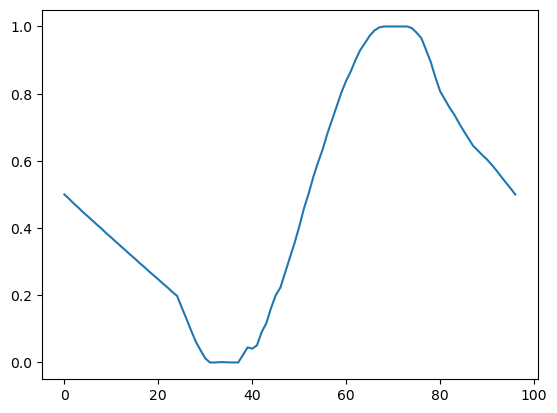

In [39]:
plt.plot(sol.sol["bat_e"][0]/sol.sol["bat_capacity"])

In [37]:
b = 2
"a{}".format(b)

'a2'

throughput 1.000204081632653
Crate 0.855309717359965
rainflow 1.113618160479359
DOD 1.110226530612245


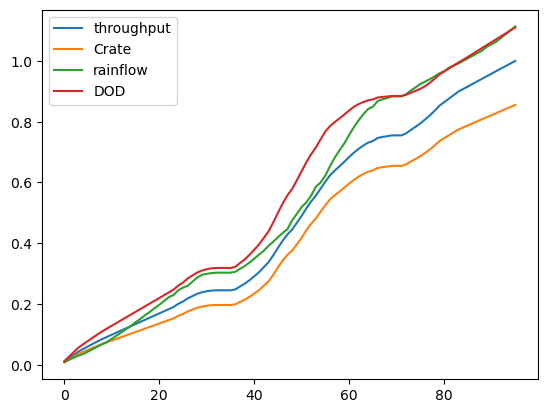

In [40]:
for m in hist.keys():
    y = np.array(hist[m])
    plt.plot(range(96), y.cumsum(), label=m)
    print(m, y.sum())
plt.legend()

In [16]:
np.array(sol.params["S_prob"])

array([1.])

In [7]:
sol.battery.params["bat_capacity"]

165.4305782514324

In [8]:
sol.battery_est.params["bat_capacity"]

throughput 0.6839943408272132
Crate 0.6312607244695773
rainflow 0.5471954726617707
DOD 1.059070871439458


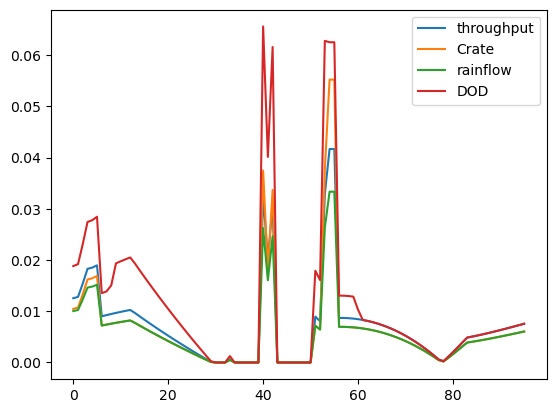

In [5]:
cycle_history = opt.cache["cycle_history"][0]
for m in cycle_history.keys():
    plt.plot(range(96), np.array(cycle_history[m]), label=m)
    print(m, sum(cycle_history[m]))
    plt.legend()

In [6]:
sol["eq_cycles"]

array([1.36986301])

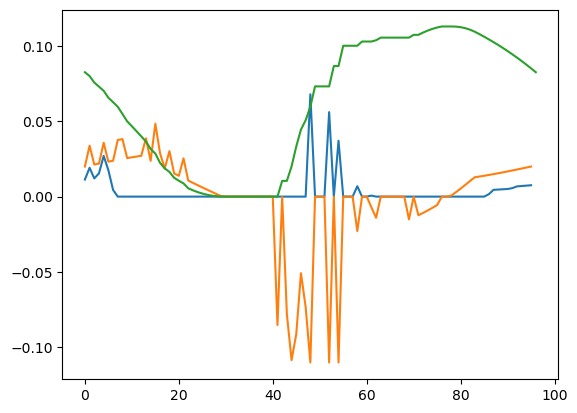

In [18]:
plt.plot(cycle_history["DOD"])
plt.plot(sol["bat_p"][0]/500)
plt.plot(sol["bat_e"][0]/1000)

In [8]:
delta = 0.25
e_prev = sol["bat_e"][0][0]
ps = sol["bat_p"][0]
bat_capacity = sol["bat_capacity"]
eta = 0.98
ps_eta = np.maximum(ps, 0)/eta + np.minimum(ps, 0)*eta
es = np.zeros(len(ps)+1)
es[0] = e_prev
es[1:] = e_prev - ps_eta.cumsum()*delta

thres = np.array((0.25,0.25,0.25,0.25)) * bat_capacity    # shape = (J,)
lams = np.array((2,1.5,1, 0.8))
thres_cum = thres.cumsum() - thres

e_js = np.clip(es - thres_cum[:,None], 0, thres[:,None]) # shape = (J, N+1)
p_js_eta = (e_js[:,1:] - e_js[:,:-1])/delta     # shape = (J, N)
p_js = np.maximum(p_js_eta, 0)/eta + np.minimum(p_js_eta, 0)*eta
eq_cycles = (np.abs(p_js) * lams[:,None]).sum(axis=0) * (0.5 * 0.25 / bat_capacity)

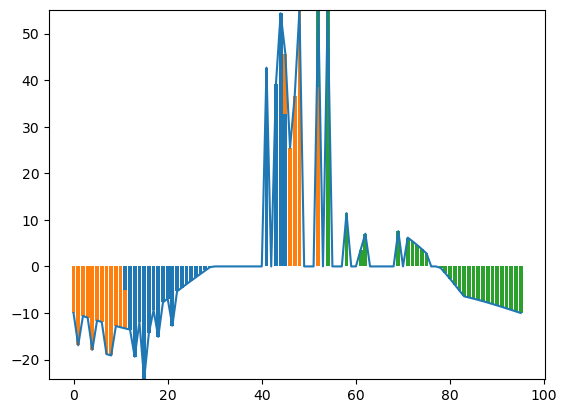

In [11]:
for i in range(4):
    low = 0 if i == 0 else p_js[:i].sum(axis=0)
    plt.bar(range(96), p_js[i], bottom=low)
plt.plot(- sol["bat_p"][0])

In [3]:
from predictor import Predictor_tou_CAISO, Predictor_tou_SDGE_DA

In [4]:
from datetime import datetime

In [6]:
tou1 = Predictor_tou_CAISO(None)
pred1 = tou1.get_prediction(datetime(2019,1,1,0,0), 24, 1)
tou2 = Predictor_tou_SDGE_DA(None)
pred2 = tou2.get_prediction(datetime(2019,1,1,0,0), 24, 1)

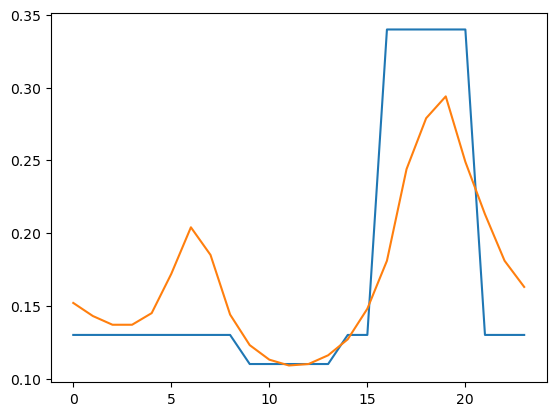

In [7]:
plt.plot(pred1)
plt.plot(pred2)